**Question:**

What factors best predict a film’s financial success - seasonality, user rating, or opening weekend? (using data from 2000 to 2013)


## Data Pipeline

### MongoDB Aggregation Pipeline

#### **$Project Stage**
```
$ project 
{
  title: "$title",
  director: "$director",
  runtime: "$runtime",
  user_rating: "$user_rating",
  is_gross_sales_usd: {
    $regexMatch: {
      input: "$gross_sales",
      regex: RegExp("^\\$")
    }
  },
  gross_sales: {
    $regexFind: {
      input: "$gross_sales",
      regex: RegExp("([\\d,]+)")
    }
  },
  is_budget_usd: {
    $regexMatch: {
      input: "$budget",
      regex: RegExp("^\\$")
    }
  },
  budget: {
    $regexFind: {
      input: "$budget",
      regex: RegExp("([\\d,]+)")
    }
  },
  is_opening_weekend_usd: {
    $regexMatch: {
      input: "$opening_weekend",
      regex: RegExp("^\\$")
    }
  },
  opening_weekend: {
    $regexFind: {
      input: "$opening_weekend",
      regex: RegExp("([\\d,]+)")
    }
  },
  mpaa: "$certification",
  all_certs: {
    $split: ["$certification", ", "]
  },
  release_date: {
    $convert: {
      input: "$release_date",
      to: "date",
      onError: null
    }
  }
}
```
#### **$addFields Stage**
```
$ addFields
{
  gross_sales: {
    $switch: {
      branches: [
        {
          case: "$is_gross_sales_usd",
          then: {
            $replaceAll: {
              input: "$gross_sales.match",
              find: ",",
              replacement: ""
            }
          }
        }
      ],
      default: null
    }
  },
  budget: {
    $switch: {
      branches: [
        {
          case: "$is_budget_usd",
          then: {
            $replaceAll: {
              input: "$budget.match",
              find: ",",
              replacement: ""
            }
          }
        }
      ],
      default: null
    }
  },
  opening_weekend: {
    $switch: {
      branches: [
        {
          case: "$is_opening_weekend_usd",
          then: {
            $replaceAll: {
              input: "$opening_weekend.match",
              find: ",",
              replacement: ""
            }
          }
        }
      ],
      default: null
    }
  },
  mpaa: {
    $first: {
      $setIntersection: [
        "$all_certs",
        ["G", "PG", "PG-13", "R", "NC-17"]
      ]
    }
  },
  release_year: {
    $year: "$release_date"
  },
  release_month: {
    $month: "$release_date"
  }
}
```

### Loading the IMDB Data into the Jupytr Notebook using the Aggregation pipeline

In [84]:
import json

# Demonstration of how to load a file that contains secrets without accidentally leaking those secrets
with open('/Users/arianamoreyra/DATA 320/my-secrets.json') as f:
    data = json.load(f)

    # If you want your data to be secure, don't print this variable out!
    # Jupyter will retain a cached version of any printed data and it can be
    # accidentally committed to version control.
    # Make sure the item in the '' is the name of the key of the connection string in the json file
secret_key = data['my-secret-key']

# We can safely print the length of the secret key. That won't leak any sensitive information.
print(f"My Secret Key is {len(secret_key)} characters in length.")

My Secret Key is 74 characters in length.


In [85]:
# Installing pymongo
## !pip install pymongo

# Importing Packages
import pymongo
import certifi

# Connect to the database using known good certificates
client = pymongo.MongoClient(secret_key, tlsCAFile=certifi.where())
db = client.DATA320
all_collections = db.list_collection_names()
print(f"This database has the collections {all_collections}")


This database has the collections ['IMDB', 'IMDBFixed', 'Metacritic', 'IMDBF_pipeline_view']


### Retrieving IMDB and Metacritic Data from MongoDB & Filtering Data by Year

In [86]:
import pandas

# Finding data from IMDB 
imdb_view = pandas.DataFrame(db.IMDBF_pipeline_view.find())

# Finding data from Metacritic 
metacritic_view = pandas.DataFrame(db.Metacritic.find())

# Converting metacritic values to numbers 
metacritic_view.score = pandas.to_numeric(metacritic_view.score, errors='coerce')
metacritic_view.release_date = pandas.to_datetime(metacritic_view.release_date, errors='coerce')

# converting imdb values to numbers and datetime
imdb_view['budget'] = pandas.to_numeric(imdb_view['budget'], errors='coerce')
imdb_view['gross_sales'] = pandas.to_numeric(imdb_view['gross_sales'], errors='coerce')
imdb_view['opening_weekend'] = pandas.to_numeric(imdb_view['opening_weekend'], errors='coerce')
imdb_view['release_date'] = pandas.to_datetime(imdb_view['release_date'], errors='coerce')

In [87]:
# Checking what years my current release date data ranges to create a filter  
print("Release year range:", imdb_view['release_year'].min(), "to", imdb_view['release_year'].max())
print("Release date range:", metacritic_view['release_date'].min(), "to", metacritic_view['release_date'].max())

Release year range: 1978 to 2013
Release date range: 2000-01-01 00:00:00 to 2020-12-30 00:00:00


After checking the date ranges in each dataset, I found that the IMDB data spans from 1978 to 2013, while the Metacritic data ranges from 2000 to 2020. To ensure consistency and reliability when comparing metrics like gross sales (from IMDB) and critic scores (from Metacritic), I limited the analysis to the overlapping years between 2000 and 2013. This ensures all data points used in the analysis are complete and directly comparable across both sources.

In [88]:
# Dropping rows with missing / invalid release years
imdb_view = imdb_view.dropna(subset=['release_year'])

# Extracting year from Metacritic release_date
metacritic_view['release_year'] = metacritic_view['release_date'].dt.year

# Filter both datasets to include only years from 2000 to 2013 
imdb_view = imdb_view[(imdb_view['release_year'] >= 2000) & (imdb_view['release_year'] <= 2013)]
metacritic_view = metacritic_view[(metacritic_view['release_year'] >= 2000) & (metacritic_view['release_year'] <= 2013)]

### Merging the Two Datasets by Movie Title and Release Year

In [89]:
# Merging the data by title and release year to ensure accuracy with analysis
unified_view = pandas.merge(imdb_view, metacritic_view, how="left", on=["title", "release_year"]) # Using left to preserve IMDB data
unified_view.head()

,_id_x,title,director,runtime,votes,user_rating,is_gross_sales_usd,gross_sales,is_budget_usd,budget,...,all_certs,release_date_x,release_year,release_month,_id_y,movie_id,release_date_y,description,score,thumbnail
0,6366e494fcbf171967d87a2d,Superman II: The Richard Donner Cut,"Richard Donner, Richard Lester",116.0,17220,7.6,False,NaN,True,54000000.0,...,[PG],2006-11-02,2006,11,NaN,NaN,NaT,NaN,NaN,NaN
1,636ac9d6d62a76b6b8c6737f,Drawing Flies,"Matthew Gissing, Malcolm Ingram",76.0,1432,5.2,False,NaN,False,NaN,...,None,2002-02-26,2002,2,NaN,NaN,NaT,NaN,NaN,NaN
2,636ad13ed62a76b6b8c67674,L.E.T.H.A.L. Ladies: Return to Savage Beach,Andy Sidaris,98.0,1388,3.7,False,NaN,False,NaN,...,[R],2006-02-14,2006,2,NaN,NaN,NaT,NaN,NaN,NaN
3,636b02123bc31743d94b4bc3,Serendipity,Peter Chelsom,90.0,113946,6.8,True,77516304.0,True,28000000.0,...,[PG-13],2001-09-13,2001,9,681d93d0789823c68c3f0134,11814.0,2001-10-05,They met by chance and spent the perfect night...,52.0,https://static.metacritic.com/images/products/...
4,636b02143bc31743d94b4bc4,Frailty,Bill Paxton,100.0,84897,7.2,False,NaN,True,11000000.0,...,[R],2001-11-17,2001,11,NaN,NaN,NaT,NaN,NaN,NaN


### Regression Analysis

In [90]:
import statsmodels.formula.api

# Regression Analysis 
ols_model = statsmodels.formula.api.ols(
    formula = "gross_sales ~ user_rating + budget + opening_weekend + score + votes",
    data = unified_view).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:            gross_sales   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     656.2
Date:                Sun, 01 Jun 2025   Prob (F-statistic):          1.39e-321
Time:                        21:10:38   Log-Likelihood:                -21227.
No. Observations:                1067   AIC:                         4.247e+04
Df Residuals:                    1061   BIC:                         4.249e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -7.98e+07   2.69e+07     

# Charting

To further explore the research question, we will examine opening weekend sales, seasonality, and user ratings to assess how strongly these factors influence a film’s long-term financial success.

In [95]:
# Filtering data
filtered_opening = unified_view[
    (unified_view['opening_weekend'].notnull()) &
    (unified_view['gross_sales'].notnull()) &
    (unified_view['votes'].notnull()) &
    (unified_view['gross_sales'] > 0) &
    (unified_view['opening_weekend'] > 0)
]

### Chart No. 1 How relevant opening weekend is to the long-term box office success of a film

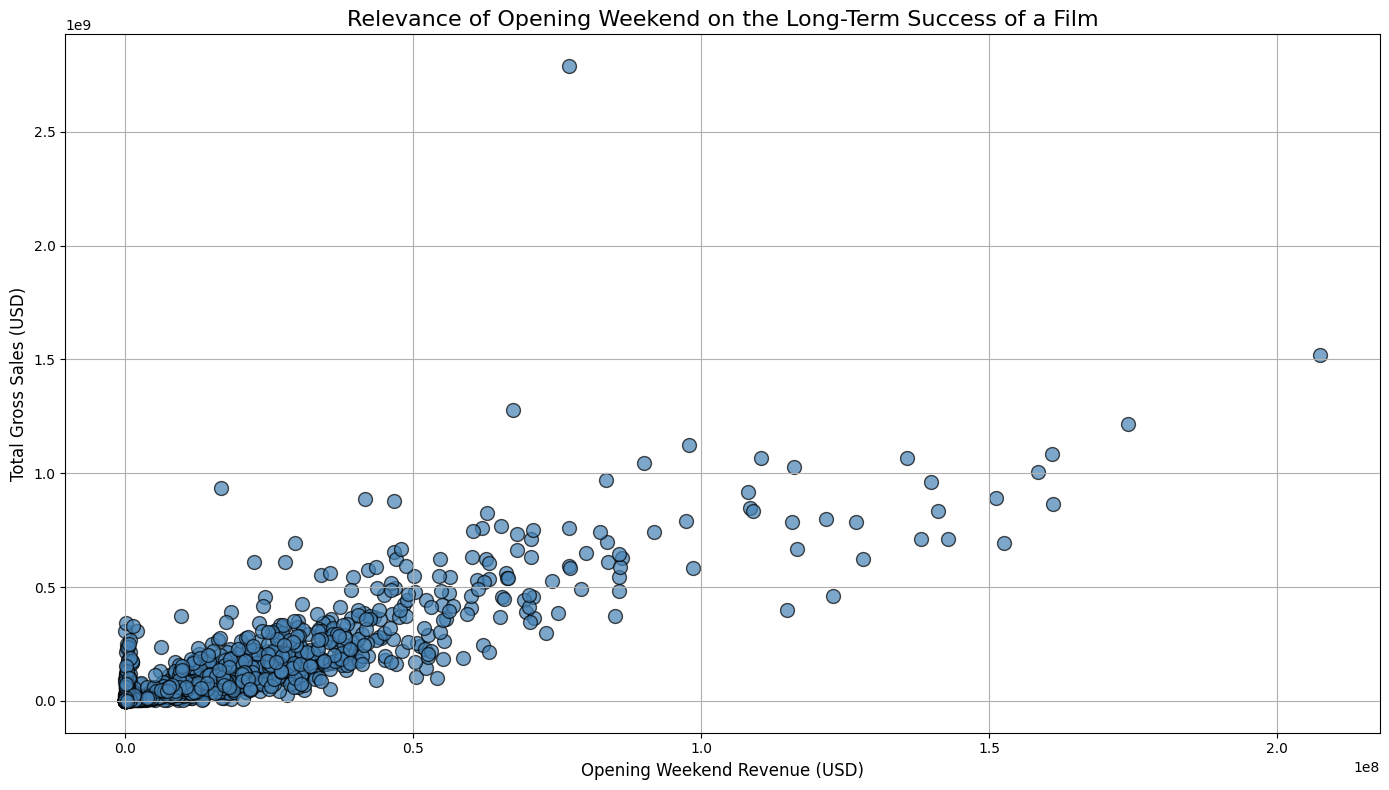

In [ ]:
import matplotlib.pyplot as plt

# Create the scatter plot 
plt.figure(figsize=(14, 8))
plt.scatter(
    filtered_opening['opening_weekend'],
    filtered_opening['gross_sales'],
    color='steelblue',
    s=100,                # Circle size 
    alpha=0.7,
    edgecolors='black'
)

# Labeling the plot
plt.title("Relevance of Opening Weekend on the Long-Term Success of a Film", fontsize=16)
plt.xlabel("Opening Weekend Revenue (USD)", fontsize=12)
plt.ylabel("Total Gross Sales (USD)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### Chart No. 2 How does the User Rating of a Film Impact Overall Box Office Success

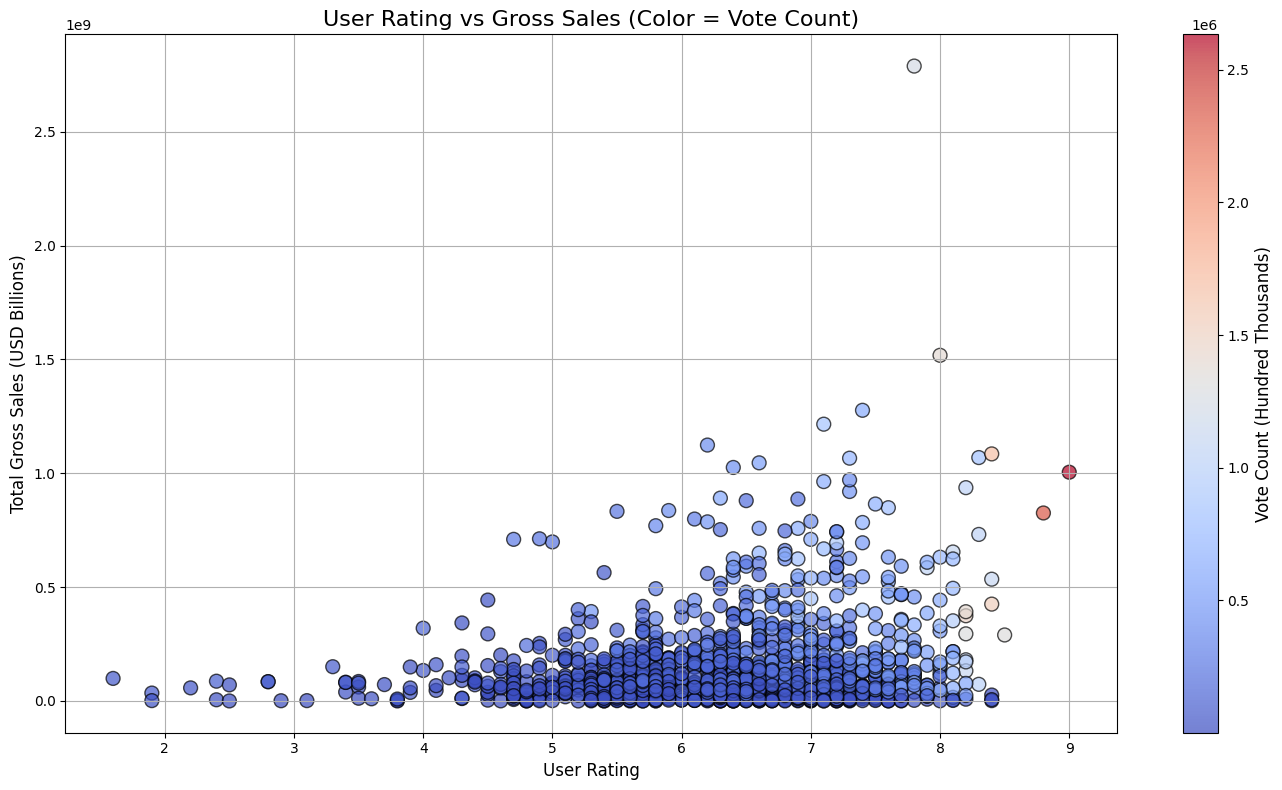

In [99]:
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(14, 8))
scatter = plt.scatter(
    filtered_opening['user_rating'],
    filtered_opening['gross_sales'],
    c=filtered_opening['votes'],
    cmap='coolwarm',
    s=100,
    alpha=0.7,
    edgecolors='black'
)

# Add color bar to show vote counts
cbar = plt.colorbar(scatter)
cbar.set_label('Vote Count (Hundred Thousands)', fontsize=12)

# Plot labels and title
plt.title("User Rating vs Gross Sales (Color = Vote Count)", fontsize=16)
plt.xlabel("User Rating", fontsize=12)
plt.ylabel("Total Gross Sales (USD Billions)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### Chart No. 3 How Seasonality Related to Overall Financial Performance

/var/folders/y2/p4jf90tx6g76q_7bj869726r0000gn/T/ipykernel_66559/986290154.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette='viridis')


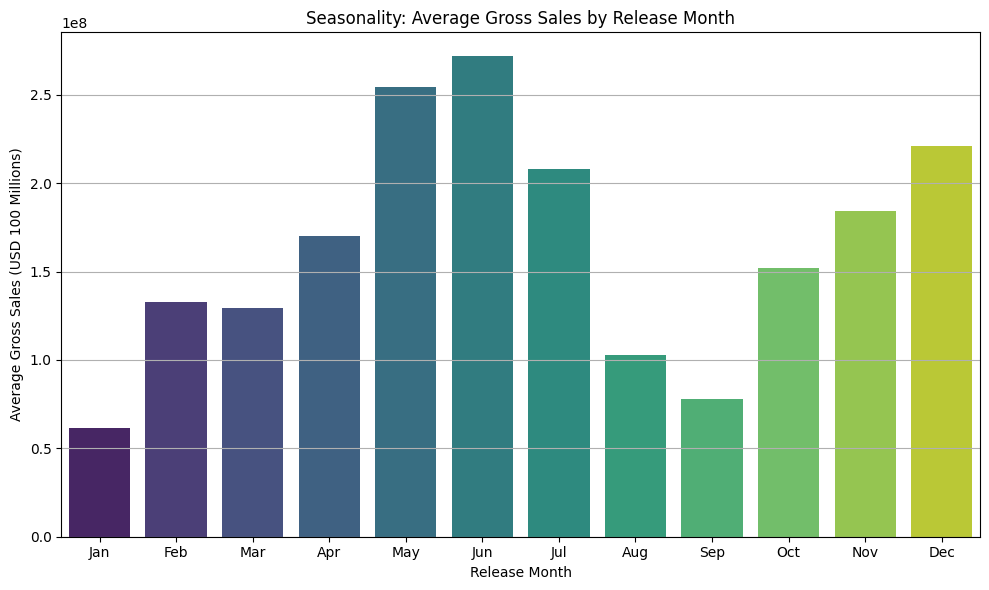

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtering the data
monthly_avg = (
    filtered_opening.groupby('release_month')['gross_sales']
    .mean()
    .reindex(range(1, 13))
)

# Creating the Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette='viridis')
plt.xlabel('Release Month')
plt.ylabel('Average Gross Sales (USD 100 Millions)')
plt.title('Seasonality: Average Gross Sales by Release Month')
plt.xticks(ticks=range(0, 12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Conclusions

### What these plots teach me

**Question:** What factors best predict a film’s financial success - seasonality, user rating, or opening weekend? (using data from 2000 to 2013)



**Chart 1 How relevant opening weekend is to the long-term box office success of a film**

This first chart looks at the relationship between a films opening weekend and long-term financial success. This chart showed a relatively strong indicator of financial success. As shown in the first chart, there is an upward trend between opening weekend revenue and total gross sales. Films with stronger openings tend to earn more overall, suggesting that early momentum plays a role in shaping long-term financial performance. 


**Chart 2 How does the User Rating of a Film Impact Overall Box Office Success**

The second chart shows the relationship between user rating and a films financial success. Has a weaker relationship than chart 1, but is still notable. The second chart shows that while higher user ratings correlate somewhat with higher gross sales, the relationship is less direct than with opening weekend revenue. Some highly rated films did not perform very well at the box office, while some lower-rated films still grossed high amounts. This indicates that critical reception alone doesn't guarantee financial success.


**Chart 3 How Seasonality Related to Overall Financial Performance**

The last chart looks at the financial success of films during each month of a year. This chart did indicate that seasonality can affect box office success. Films released in May, June, and December, typically blockbuster or holiday seasons, saw the highest average gross sales. This indicates that strategic release dates are a strong factor to consider for companies aiming to maximize revenue.


**Overall Conclusion**

Based on the analysis of films released between 2000 and 2013, opening weekend revenue emerged as the strongest predictor of a film’s long-term financial success. Films with higher opening weekend earnings were more likely to achieve greater overall box office performance, suggesting that driving early momentum for a film can play a strong role in financial success. Seasonality also proved to be influential, with films released in May, June, and December, which are peak blockbuster and holiday periods, generated the highest average gross sales.

In contrast, user ratings showed a weaker relationship with financial success. While higher-rated films tended to perform better, there were exceptions. Overall, the data suggests that studios aiming to maximize revenue should prioritize strong openings and strategic release timing, while viewing audience sentiment as a secondary factor in a film’s overall financial success.
